In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [3]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/polyp"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/polyp/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [4]:
import yaml

# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [5]:
config

{'mean_RGB_values_path': None,
 'ml_data_dir': 'data/polyp/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 1024,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/polyp/03_model_weights/resnet',
 'polyp': True,
 'probas_dir': 'data/polyp/04_predictions'}

In [9]:
IMG_SIZE = 64
EMBEDDING_SIZE = config["model"]["embedding_size"]

In [10]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [15]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        # target_size = pred_proba.shape[0] // IMG_SIZE, pred_proba.shape[1] // IMG_SIZE
        target_size = (IMG_SIZE, IMG_SIZE)
        pred_probas[i] = cv2.resize(pred_proba, target_size)
        # pred_probas.append(cv2.resize(pred_proba, target_size))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, target_size) > .5    
        # labels.append(cv2.resize(label, target_size) > .5)
    return pred_probas, res_emb, labels


In [16]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


0it [00:00, ?it/s]

252it [00:14, 17.32it/s]


In [17]:
test_pred_probas, test_res_emb, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

0it [00:00, ?it/s]

546it [00:06, 82.11it/s] 


In [18]:
index_not_empty = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
# index_not_empty = [i for i in range(len(cal_labels)) if cal_labels[i].sum() > 0]
cal_labels = cal_labels[index_not_empty]  # [cal_labels[i] for i in index_not_empty]
cal_res_emb = cal_res_emb[index_not_empty]
cal_pred_probas = cal_pred_probas[index_not_empty]

In [19]:
len(cal_labels), cal_res_emb.shape, len(cal_pred_probas)

(252, (252, 1024), 252)

In [54]:
ALPHA = .1
N = len(cal_labels)
REGULIZATION = "ridge"


In [85]:
def grid_search_lambda(labels, pred_probas, res_emb):
    lambdas = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
    best_dist = np.inf
    best_lambda = None
    cv = len(lambdas)
    # get cv indices
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    for i, lambda_ in enumerate(tqdm(lambdas)):
        test_labels = labels[indices[i]]
        test_pred_probas = pred_probas[indices[i]]
        test_res_emb = res_emb[indices[i]]
        cal_labels = np.concatenate([labels[indices[j]] for j in range(cv) if j != i])
        cal_pred_probas = np.concatenate([pred_probas[indices[j]] for j in range(cv) if j != i])
        cal_res_emb = np.concatenate([res_emb[indices[j]] for j in range(cv) if j != i])
        
        result = minimize(
            J, np.random.uniform(0, 1, EMBEDDING_SIZE),
            method="SLSQP",
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N, REGULIZATION, lambda_), jac=J_prime,
            options={"disp": False, "maxiter": 10000}
        )
        ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        test_res_emb.shape
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
        if (np.abs(recall_test - 1)) < best_dist:
            best_dist = np.abs(recall_test - (1 - ALPHA))
            best_lambda = lambda_
        
    return best_lambda, best_dist
        

In [86]:
best_lambda, best_dist = grid_search_lambda(cal_labels, cal_pred_probas, cal_res_emb)
print(best_lambda, best_dist)
result = minimize(
    J, np.random.uniform(0, 1, EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N, REGULIZATION, best_lambda), jac=J_prime,
    options={"disp": True, "maxiter": 10000}
    
)
result.x.min()

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_1753540/880049878.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
100%|██████████| 7/7 [01:14<00:00, 10.65s/it]


0.2 0.03552643413862788
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.62668061606851
            Iterations: 15
            Function evaluations: 23
            Gradient evaluations: 15


-0.007543119322250017

In [87]:
ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
test_res_emb.shape
y_pred_test_th = (test_pred_probas >= ths).astype(int)
recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)
np.nanmean(recall_test), 1 - ALPHA + 1/N

/tmp/ipykernel_1753540/1886035650.py:5: RuntimeWarning: invalid value encountered in divide
  recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)


(0.9011902774864465, 0.903968253968254)

In [88]:
precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
np.mean(precision_test)

/tmp/ipykernel_1753540/3317103724.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)


0.4262679294305455

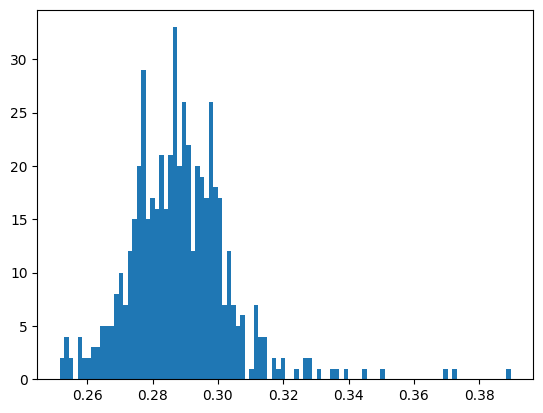

In [89]:
plt.hist(ths[:, 0, 0], bins=100)
plt.show()

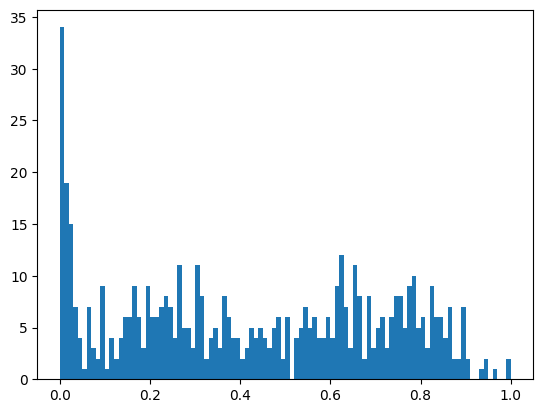

In [90]:
plt.hist(precision_test, bins=100)
plt.show()

In [61]:
np.median(precision_test)

0.5007359241548965

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.17it/s]/tmp/ipykernel_1753540/1318275809.py:6: RuntimeWarning: invalid value encountered in divide
  precision = np.nan_to_num((pred_th * test_labels).sum(axis=(1, 2)) / pred_th.sum(axis=(1, 2)), nan=1)
100%|██████████| 100/100 [00:00<00:00, 162.13it/s]


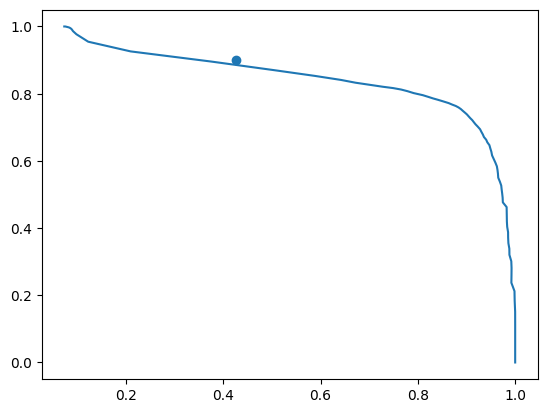

In [93]:
recalls = []
precisions = []
for th in tqdm(np.linspace(0, 1, 100)):
    pred_th = test_pred_probas >= th
    recall = (pred_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
    precision = np.nan_to_num((pred_th * test_labels).sum(axis=(1, 2)) / pred_th.sum(axis=(1, 2)), nan=1)
    recalls.append(np.nanmean(recall))
    precisions.append(np.nanmean(precision))

plt.plot(precisions, recalls)
plt.scatter(np.nanmean(precision_test), np.nanmean(recall_test))